<a href="https://colab.research.google.com/github/YazCodes/heartRatePrediction/blob/main/Lorenz_heart_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib


In [72]:
#load the data 
df = pd.read_csv('/content/PT_Train.csv')

df.head() #look at the data

#print(f'Number of entries: {len(df)}') #print number of data entries 


,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [73]:
#Data cleaning  - Important step as the ML model and data processing cannot start if the dataset contains missing values

df.isnull().values.any() #This shows if there are any missing values in the dataset. True = yes false = No

df = df.dropna() #drop any rows with missing values 

df= df.drop(['Lifetouch Respiration Rate', 'Oximeter SpO2','Oximeter Pulse'], axis= 'columns')

#df.head()


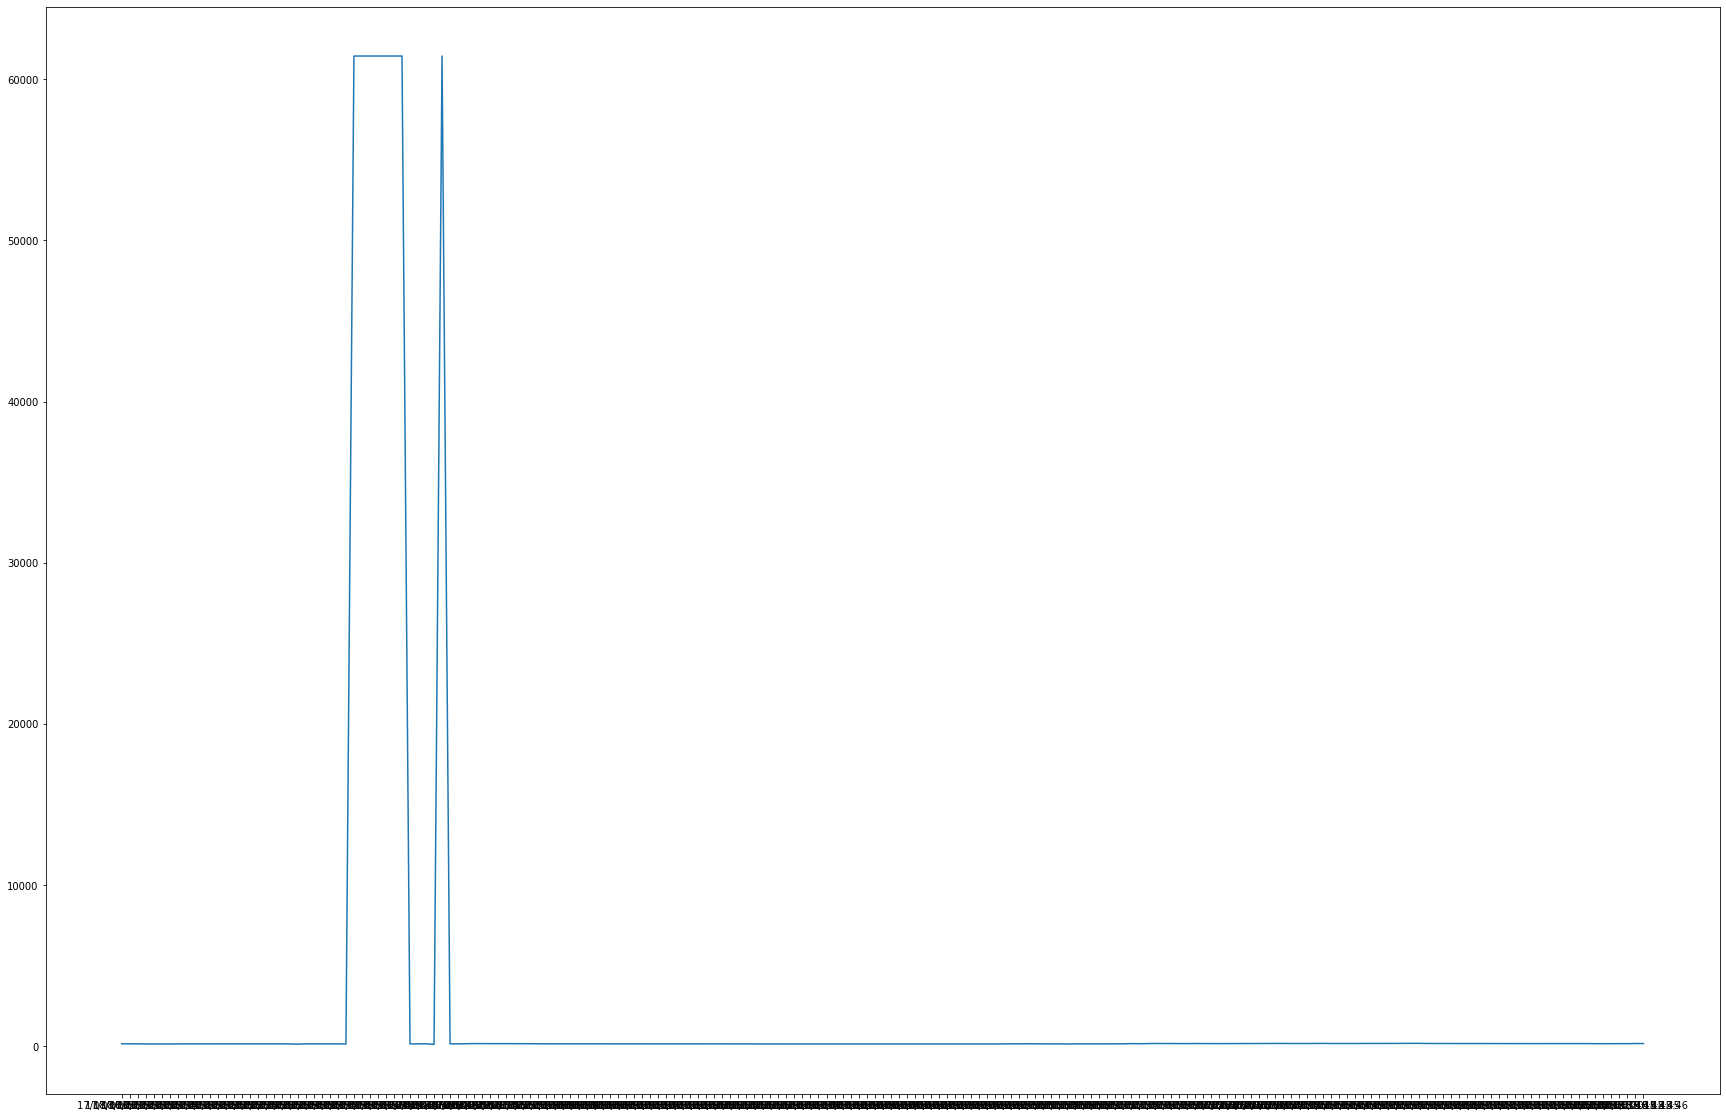

In [74]:
#Plot your data 

plt.plot(df['Timestamp (GMT)'],df['Lifetouch Heart Rate'])

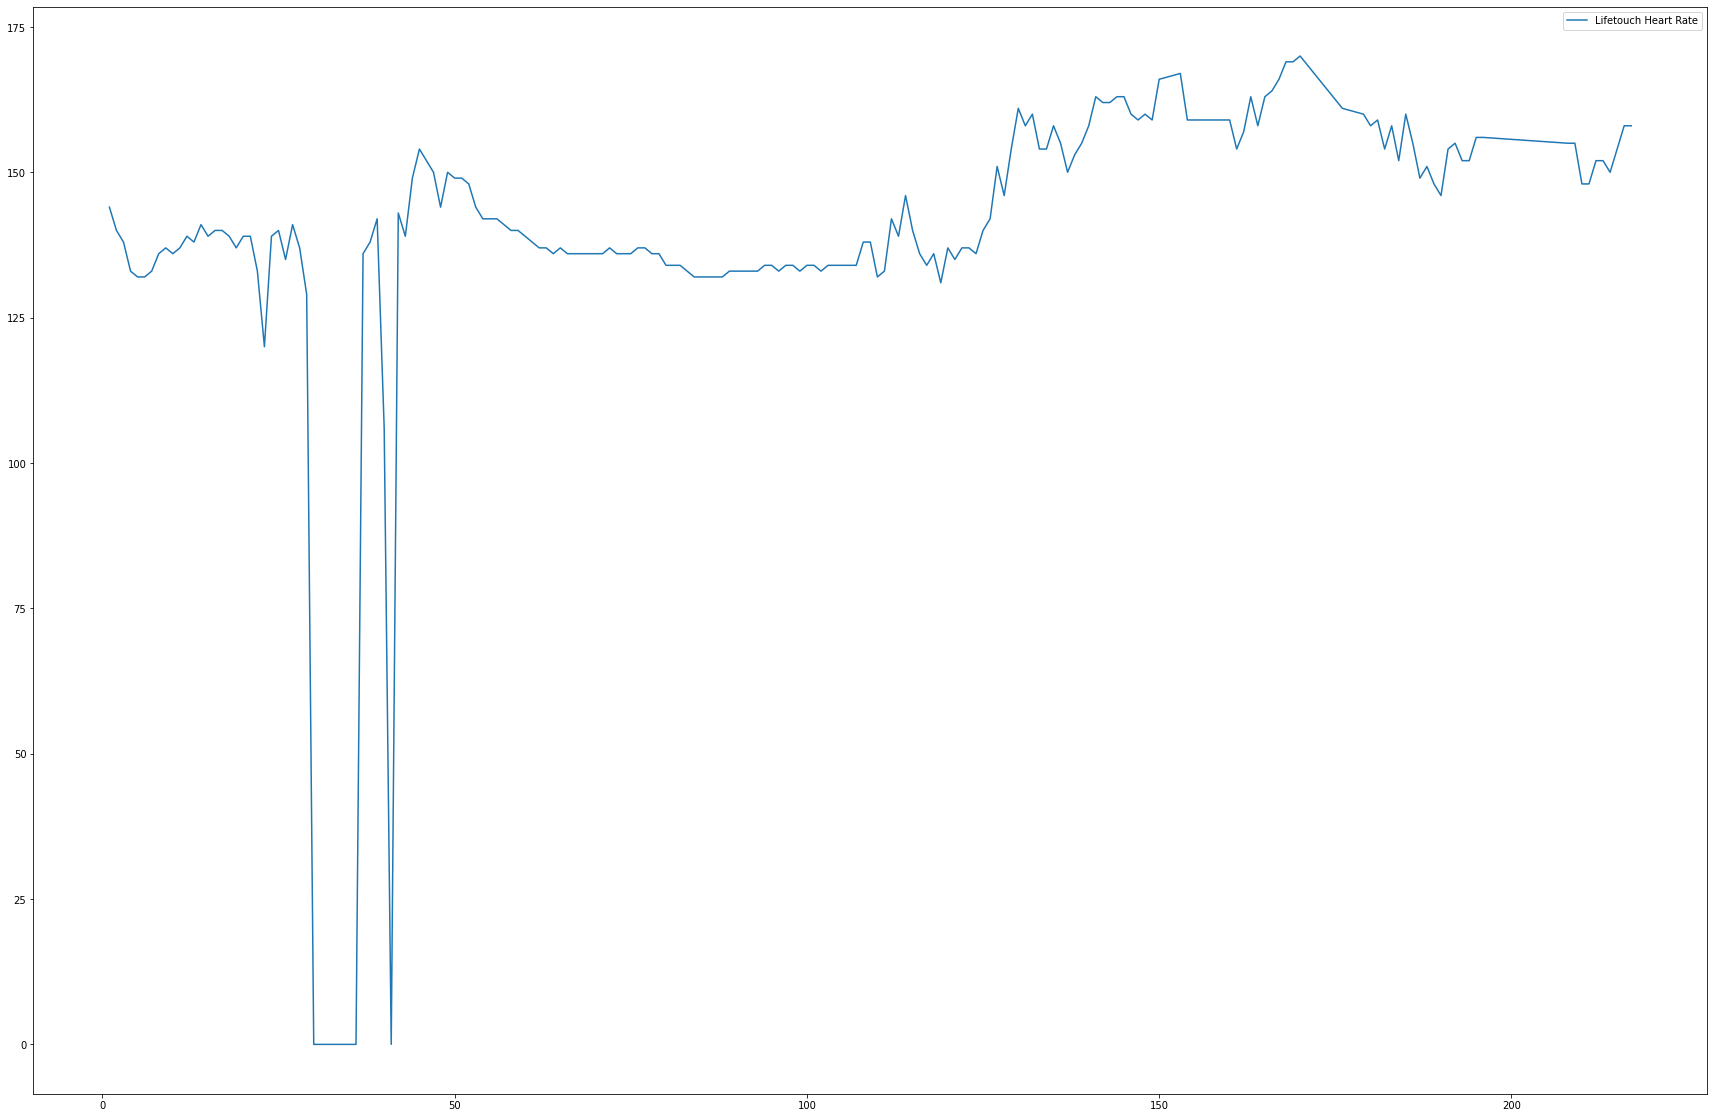

In [75]:
#Cut off function
def cutoff(row):
    vals = row
    if vals>1000:
        vals = 0  #Any value > 1000 will be set to 0 
    return vals

matplotlib.rc('figure', figsize=(30, 20))
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(cutoff)
df.plot()

In [76]:
#Data cleaning continued 
print("Number of null values:")
print(sum(df['Lifetouch Heart Rate'].isnull()))
print("Number of N\A values:")
print(sum(df['Lifetouch Heart Rate'].isna()))
print("Number of low values (>2000):")
print(sum(df['Lifetouch Heart Rate']> 2000)) 

df.isnull().values.any()

Number of null values:
0
Number of N\A values:
0
Number of low values (>2000):
0


False

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)



Result: the time series is not stationary



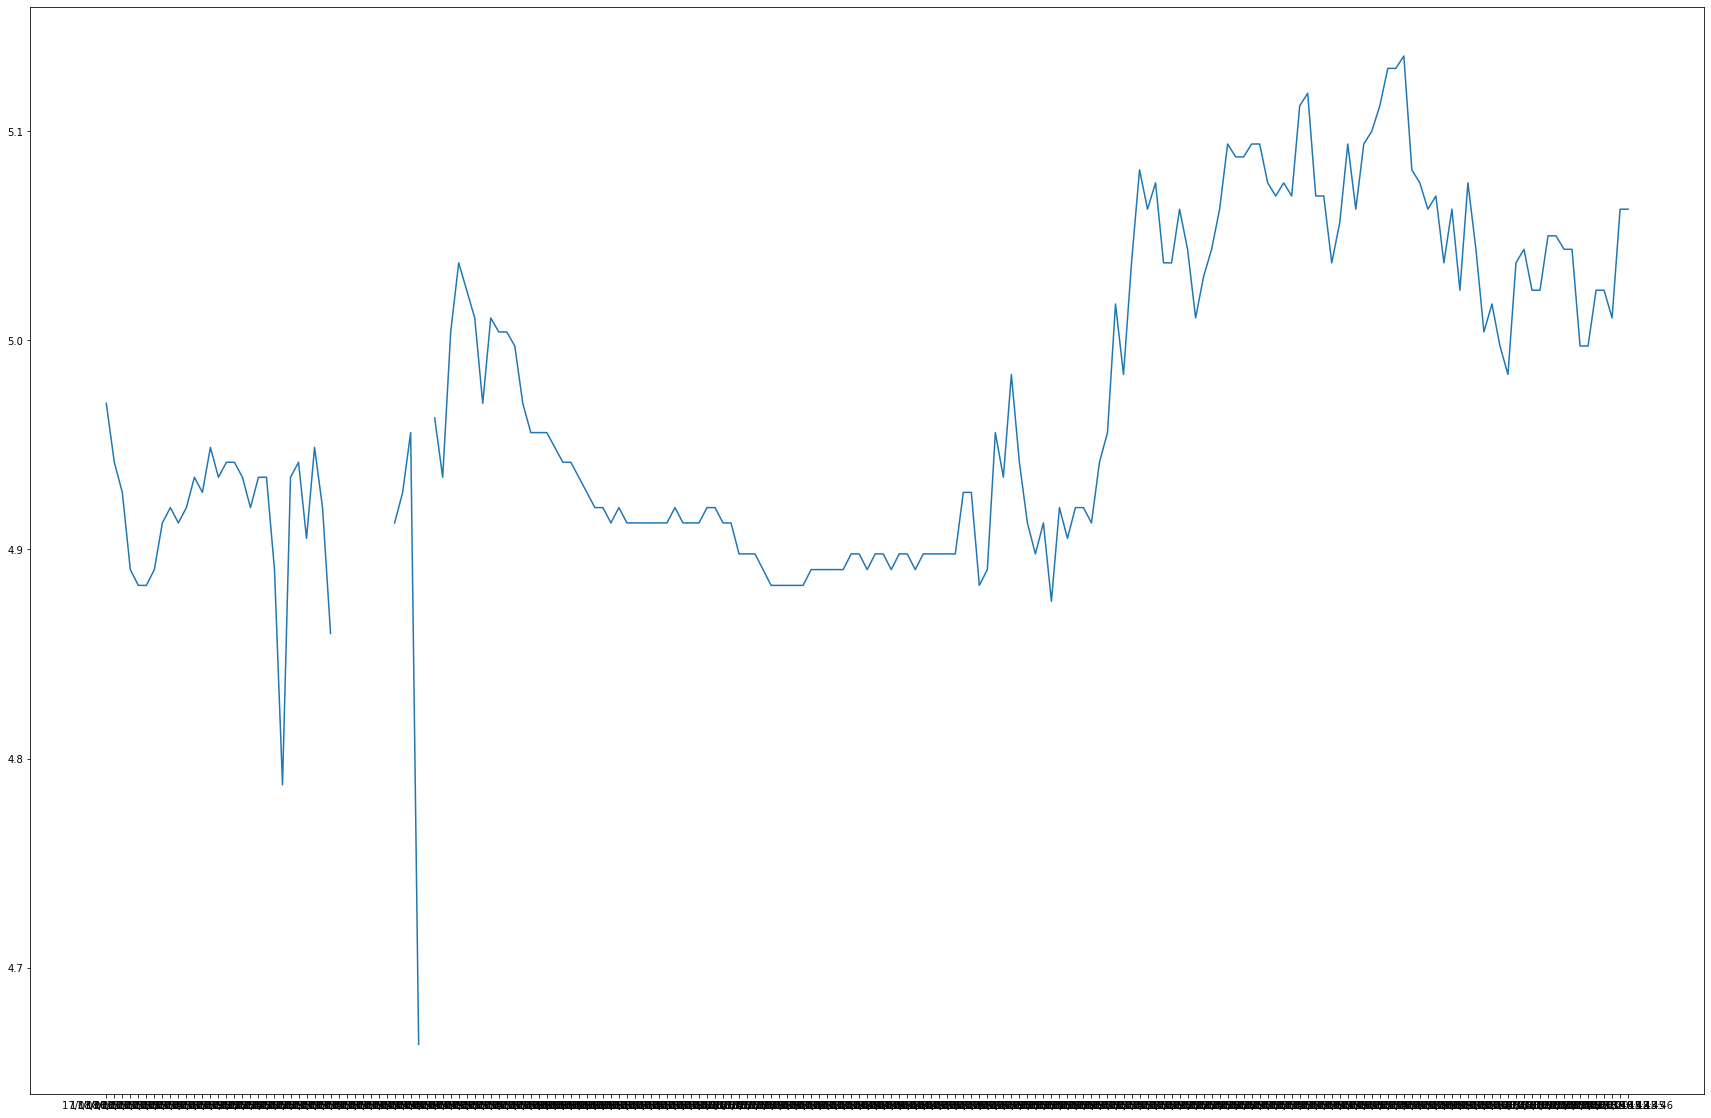

,Timestamp (GMT),Lifetouch Heart Rate,stationary
1,17/08/2015 15:10,144,4.969813
2,17/08/2015 15:11,140,4.941642
3,17/08/2015 15:12,138,4.927254
4,17/08/2015 15:13,133,4.890349
5,17/08/2015 15:14,132,4.882802


In [77]:
#Step one - check if data is stationary using the KPSS test 
df['stationary'] = np.log(df['Lifetouch Heart Rate'])

statistic,p_value,n_lags,critical_values= sm.tsa.stattools.kpss(df['Lifetouch Heart Rate'])
print(f'\nResult: the time series is {"not" if p_value <0.05 else""} stationary\n')

plt.plot(df['Timestamp (GMT)'],df['stationary'])
plt.show()
df.head()

In [78]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,stationary
1,17/08/2015 15:10,144,4.969813
2,17/08/2015 15:11,140,4.941642
3,17/08/2015 15:12,138,4.927254
4,17/08/2015 15:13,133,4.890349
5,17/08/2015 15:14,132,4.882802


In [80]:
#Needs to make it stationary 

mons = df.pop('Timestamp (GMT)')
u = df.iloc[1]['stationary'] # swap around the order 
df=df.diff(axis=0,periods=12) # every 1st and 12th row it does what is being asked then 14th 2nd - accounts for the peaks 

plt.plot(np.linspace(1,131,131),df['stationary'][13:])
plt.show()

KeyError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)



Result: The series is stationary



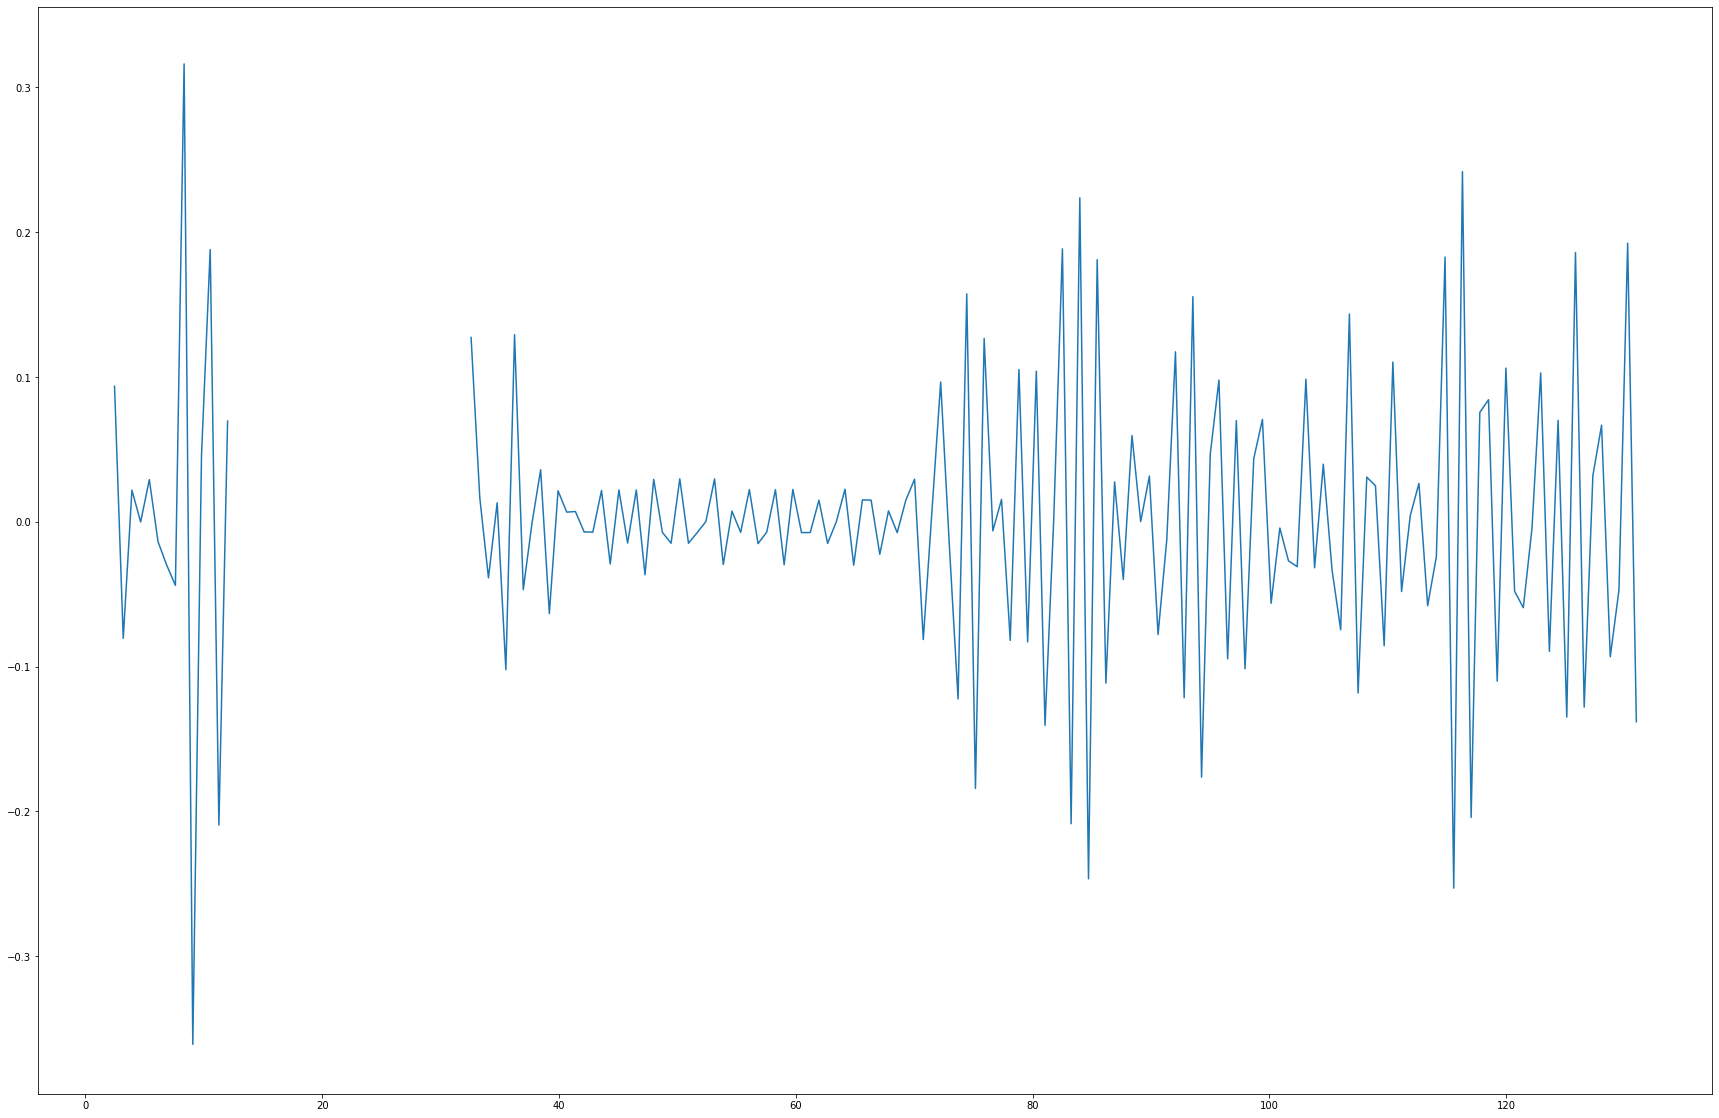

,Lifetouch Heart Rate,stationary
212,10.0,0.066669
213,-14.0,-0.093199
214,-7.0,-0.047067
216,29.0,0.192275
217,-21.0,-0.138021


In [83]:

u = df.iloc[13]['stationary']
df = df.diff(axis=0)

statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary'])
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(np.linspace(1,131,178),df['stationary'][13:])
plt.show()
df.tail()

In [100]:
df.tail()

,Lifetouch Heart Rate,stationary
212,10.0,0.066669
213,-14.0,-0.093199
214,-7.0,-0.047067
216,29.0,0.192275
217,-21.0,-0.138021


In [99]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df2['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)


Stacked data with delay embedding 3:
[[148 148 152]
 [148 152 152]
 [152 152 150]
 [152 150 158]
 [150 158 158]]

Target to predict:
158

 Latest observation:
[[150 158 158]]


In [85]:
# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]


In [97]:
#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)

Standard prediction:
158

Averaged prediction:
158.0


In [104]:
df3 = df2.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df2.tail()

,Timestamp (GMT),Lifetouch Heart Rate,stationary
187,17/08/2015 18:42,152,5.023881
188,17/08/2015 18:43,150,5.010635
189,17/08/2015 18:45,158,5.062595
190,17/08/2015 18:46,158,5.062595
191,NaN,158,NaN


**Prediction two**

In [103]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df3['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[[148 152 152]
 [152 152 150]
 [152 150 158]
 [150 158 158]
 [158 158 '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 158 155]]
Standard prediction:
158

Averaged prediction:
157.4


In [111]:
df4 = df3.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df3.tail()

,Timestamp (GMT),Lifetouch Heart Rate,stationary
188,17/08/2015 18:43,150,5.010635
189,17/08/2015 18:45,158,5.062595
190,17/08/2015 18:46,158,5.062595
191,NaN,158,NaN
192,NaN,158,NaN


**Prediction 3**

In [108]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df4['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[[152 152 150]
 [152 150 158]
 [150 158 158]
 [158 158 '158']
 [158 '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [112]:
df5 = df4.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df5.tail()

,Timestamp (GMT),Lifetouch Heart Rate,stationary
190,17/08/2015 18:46,158,5.062595
191,NaN,158,NaN
192,NaN,158,NaN
193,NaN,158,NaN
194,NaN,158,NaN


**prediction **5

In [113]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df5['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[[150 158 158]
 [158 158 '158']
 [158 '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [115]:
df6 = df5.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df6.tail(10)

,Timestamp (GMT),Lifetouch Heart Rate,stationary
186,17/08/2015 18:41,152,5.023881
187,17/08/2015 18:42,152,5.023881
188,17/08/2015 18:43,150,5.010635
189,17/08/2015 18:45,158,5.062595
190,17/08/2015 18:46,158,5.062595
191,NaN,158,NaN
192,NaN,158,NaN
193,NaN,158,NaN
194,NaN,158,NaN
195,NaN,158,NaN


**Prediction 6** 

In [117]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df6['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[[158 158 '158']
 [158 '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [118]:
df7 = df6.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df7.tail(20)

,Timestamp (GMT),Lifetouch Heart Rate,stationary
177,17/08/2015 18:21,155,5.043425
178,17/08/2015 18:22,152,5.023881
179,17/08/2015 18:23,152,5.023881
180,17/08/2015 18:24,156,5.049856
181,17/08/2015 18:25,156,5.049856
182,17/08/2015 18:37,155,5.043425
183,17/08/2015 18:38,155,5.043425
184,17/08/2015 18:39,148,4.997212
185,17/08/2015 18:40,148,4.997212
186,17/08/2015 18:41,152,5.023881


prediction 8 

In [119]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df7['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[[158 '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [120]:
df8 = df7.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df8.tail(20)

,Timestamp (GMT),Lifetouch Heart Rate,stationary
178,17/08/2015 18:22,152,5.023881
179,17/08/2015 18:23,152,5.023881
180,17/08/2015 18:24,156,5.049856
181,17/08/2015 18:25,156,5.049856
182,17/08/2015 18:37,155,5.043425
183,17/08/2015 18:38,155,5.043425
184,17/08/2015 18:39,148,4.997212
185,17/08/2015 18:40,148,4.997212
186,17/08/2015 18:41,152,5.023881
187,17/08/2015 18:42,152,5.023881


In [122]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df8['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [123]:
df9 = df8.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df9.tail(20)

,Timestamp (GMT),Lifetouch Heart Rate,stationary
179,17/08/2015 18:23,152,5.023881
180,17/08/2015 18:24,156,5.049856
181,17/08/2015 18:25,156,5.049856
182,17/08/2015 18:37,155,5.043425
183,17/08/2015 18:38,155,5.043425
184,17/08/2015 18:39,148,4.997212
185,17/08/2015 18:40,148,4.997212
186,17/08/2015 18:41,152,5.023881
187,17/08/2015 18:42,152,5.023881
188,17/08/2015 18:43,150,5.010635


In [124]:
#Time series modelling  - Lonez 
#Get our most recent data and then try to predict the closet observations to that 
x = df9['Lifetouch Heart Rate'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:") #stack data in a delay embedding of 3 h = 1 (2x1)+1 = 3
history = X[:203,:] #Look at history and compare our current observations with the history - taking the first 203 measurements of data as the history 
print(history[-5:,:]) #print an example of the history 
print("\nTarget to predict:")
test = x[190] #predict dataset 190
print(test)
latest = np.reshape(X[188,:],(-1,3)) #latest observations 
print("\n Latest observation:") #want to predict as close to this as possible 
print(latest)

# find data like most recent observation: - c
#following - closests historic observation in the data set (similar)
from scipy.spatial.distance import cdist
z = cdist(history,latest) #calculating the distance of current observations and historic ones
zz = np.argsort(z,axis=0) #find the nearest neighbours
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

#Prediction One 
pred = x[zz[0,0]+1] #predicting one day after [[150 158 158] the next predictions is 158
print("Standard prediction:")
print(pred)

#Prediction Two
print("\nAveraged prediction:")
neighbours = 5  # 5 is the optimum number of neighbours for this dataset. the most accurate performance. Look at 5 neigbours and find an average 
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+1])
print(pred2)


Stacked data with delay embedding 3:
[['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']
 ['158' '158' '158']]

Target to predict:
158

 Latest observation:
[[150 158 158]]
Five nearest neighbors from history:
[[150 158 158]
 [152 156 156]
 [152 160 155]
 [153 155 158]
 [154 161 158]]
Standard prediction:
158

Averaged prediction:
158.0


In [125]:
df10 = df9.append({'Lifetouch Heart Rate': '158' }, ignore_index=True) #1 
df10.tail(20)

,Timestamp (GMT),Lifetouch Heart Rate,stationary
180,17/08/2015 18:24,156,5.049856
181,17/08/2015 18:25,156,5.049856
182,17/08/2015 18:37,155,5.043425
183,17/08/2015 18:38,155,5.043425
184,17/08/2015 18:39,148,4.997212
185,17/08/2015 18:40,148,4.997212
186,17/08/2015 18:41,152,5.023881
187,17/08/2015 18:42,152,5.023881
188,17/08/2015 18:43,150,5.010635
189,17/08/2015 18:45,158,5.062595
